### Exploring 2018 Census Data of Higher Education Institutions

In this Notebook, we will explore and analyze data related to different aspects of Higher Education in Brazil, trying to answer some pertinent research questions. This data was gathered by the National Institute of Research and Studies on Education Anísio Teixeira (INEP), and can be found [here](http://portal.inep.gov.br/web/guest/microdados) under the census tab for the year of 2018. The data will be provided as a zipped file with different folders containing the census data in .csv files, besides a dictionary of variables and other resources, all in portuguese. Part of the challenge of this task will be to answer research questions require knowledge of behavior over time using information of just one year (2018 in our case).

To help run the notebook with the data that was used without having to download files from INEP, I have imported and saved all relevant .csv files as tables in a sqlite3 database, which I'm providing access to download in [here](https://drive.google.com/file/d/1ZX5MpjNYAIn4qSDrMVjJfr5SfUajiQvF/view?usp=sharing). The database contain 4 tables: Institutions, Courses, Students and Teachers, all of which will be used to answer the research questions posed here. Whenever we are preparing a query, we will describe each variable used in the query for clarity purposes, for all other variables in the tables please consult the dictionary provided by INEP in the first link.

In [1]:
#Importing relevant libraries and saving a path variable for the database (use the path to the folder you saved the sqtlite3 database)

import pandas as pd
import sqlite3
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

path = r'Census_Higher_Education_2018.db'

In [2]:
#Creating a connection with the database

db = sqlite3.connect(path)

#### 1) What is the number of public and private universities per state? What is the number of students per University?

To answer such questions, a simple sqlite query will do. 

To know the number of universities per state, we will use the "Institutions" table and three variables contained in such table:

- CO_UF: indicates the state of the Instituion
- TP_ORGANIZACAO_ACADEMICA: indicates the type of Higher Education Instituion (i.e. University, Faculty, Federal Institute... etc.). Of relevance to this work, "University" is coded as 1.
- TP_CATEGORIA_ADMINISTRATIVA: indicates the nature of funding for the institution (i.e. state public, federal public, non-profit private, private, etc.). Of relevance to this work, public funded institutions are coded as 1, 2 and 3, while private are coded as 4, 5, 6, 8 and 9.

To know the number of students per institution, we will use the "Students" table and the "Institutions" table.

- Variables from the "Students" table:

 - TP_ORGANIZACAO_ACADEMICA: indicates the type of Higher Education Instituion (i.e. University, Faculty, Federal Institute... etc.)
 - CO_IES: unique code that identifies a particular institution.


- Variables from the "Institutions" table:

 - CO_IES: unique code that identifies a particular institution, will be used to cross-reference the institution's name.
 - NO_IES: name of institution.

In [3]:
#Creating query to group public and private universities per state
query = """
    SELECT
    
    CO_UF as State,
    
    COUNT(
        CASE
            WHEN
                (TP_ORGANIZACAO_ACADEMICA = 1) AND
                (TP_CATEGORIA_ADMINISTRATIVA = 1 OR
                TP_CATEGORIA_ADMINISTRATIVA = 2 OR
                TP_CATEGORIA_ADMINISTRATIVA = 3)
                    THEN
                       1
        END) as Public_University,
    
    COUNT(
        CASE
            WHEN
                (TP_ORGANIZACAO_ACADEMICA = 1) AND
                (TP_CATEGORIA_ADMINISTRATIVA = 4 OR
                TP_CATEGORIA_ADMINISTRATIVA = 5 OR
                TP_CATEGORIA_ADMINISTRATIVA = 6 OR
                TP_CATEGORIA_ADMINISTRATIVA = 8 OR
                TP_CATEGORIA_ADMINISTRATIVA = 9)
                    THEN
                        1
        END) as Private_University
    
    FROM Institutions
    
    GROUP BY State;
    """

#Querying the database and transfering result to pandas dataframe
queryResult = pd.read_sql_query(query, db)

#Substituting states' number codes per states' acronyns and setting them as index
my_dict = {11: "RO", 12: "AC", 13: "AM", 14: "RR", 15: "PA", 16: "AP", 17: "TO",
          21: "MA", 22: "PI", 23: "CE", 24: "RN", 25: "PB", 26: "PE", 27: "AL", 28: "SE", 29: "BA",
          31: "MG", 32: "ES", 33: "RJ", 35: "SP",
          41: "PR", 42: "SC", 43: "RS",
          50: "MS", 51: "MT", 52: "GO", 53: "DF"}

queryResult['State'] = queryResult['State'].map(my_dict)
queryResult.set_index('State', inplace = True)

#Displaying result
queryResult

,Public_University,Private_University
State,,
RO,1,0
AC,1,0
AM,2,1
RR,2,0
PA,5,1
AP,2,0
TO,2,0
MA,3,1
PI,2,0


In [4]:
#Creating query to group students per university
query = """
    SELECT
    
    i.NO_IES as Name,
    count(s.CO_IES) as No_of_Students
    
    FROM Students as s,
         Institutions as i
    
    WHERE s.TP_ORGANIZACAO_ACADEMICA = 1 AND s.CO_IES = i.CO_IES
    
    GROUP BY Name;
    """
#Querying the database and transfering result to pandas dataframe
queryResult = pd.read_sql_query(query,db)

#Setting Uni code as index
queryResult.set_index('Name', inplace = True)

#Displaying result
queryResult

,No_of_Students
Name,
FUNDAÇÃO UNIVERSIDADE DO ESTADO DE SANTA CATARINA,14751
FUNDAÇÃO UNIVERSIDADE FEDERAL DA GRANDE DOURADOS,8750
FUNDAÇÃO UNIVERSIDADE FEDERAL DE CIÊNCIAS DA SAÚDE DE PORTO ALEGRE,2872
FUNDAÇÃO UNIVERSIDADE FEDERAL DE RONDÔNIA,12948
FUNDAÇÃO UNIVERSIDADE FEDERAL DO ABC,15888
FUNDAÇÃO UNIVERSIDADE FEDERAL DO PAMPA - UNIPAMPA,14689
FUNDAÇÃO UNIVERSIDADE FEDERAL DO TOCANTINS,18493
FUNDAÇÃO UNIVERSIDADE FEDERAL DO VALE DO SÃO FRANCISCO,8607
Fundação Universidade Virtual do Estado de São Paulo,55352


#### 2) Are there less women than men in courses related to the Exact Sciences (such as Math, Engineering, etc.)?

To answer such question, we will first query the database to structure the data, and then we will calculate a measure of strongness of association of the categorical variables Sex (divided in Man and Woman) and Type of Course (Exact or Non-Exact). The measure used will be [Cramér's V](https://www.spss-tutorials.com/cramers-v-what-and-why/), which is a measure that varies between 0 (no association) and 1 (strongest association possible).

We will use the "Students" table and the following variables:

- TP_SEXO: indicates the sex of the student.
- CO_CINE_ROTULO: a code that indicates the type of course the student is doing, such as Math, Statistics, Biology, etc. The code works in such a manner that the first initial numbers denote the great area of the course (such as Humanities or Natural Sciences), and the following numbers/letters provide further levels of specification. We will take advantage of that to query the database to include only courses related to the Exact Sciences. More information about this code can be found in this manual [here](http://www.ufrgs.br/sai/dados-resultados/manual_para_classificacao_de_cursos_cine_brasil_2018.pdf).

In [5]:
#Creating query to separate men and women per type of course
query = """

    SELECT
    
    TP_SEXO as Sex,

    COUNT(
        CASE
            WHEN
                (CO_CINE_ROTULO LIKE '0011A05%' OR
                CO_CINE_ROTULO LIKE '0011A06%' OR
                CO_CINE_ROTULO LIKE '0011A07%' OR
                CO_CINE_ROTULO LIKE '053%' OR
                CO_CINE_ROTULO LIKE '054%' OR
                CO_CINE_ROTULO LIKE '058%' OR
                CO_CINE_ROTULO LIKE '06%' OR
                CO_CINE_ROTULO LIKE '07%')
                    THEN
                        1
            END) as Exact,
        
    COUNT(
        CASE
            WHEN
                (CO_CINE_ROTULO NOT LIKE '0011A05%' AND
                CO_CINE_ROTULO NOT LIKE '0011A06%' AND
                CO_CINE_ROTULO NOT LIKE '0011A07%' AND
                CO_CINE_ROTULO NOT LIKE '053%' AND
                CO_CINE_ROTULO NOT LIKE '054%' AND
                CO_CINE_ROTULO NOT LIKE '058%' AND
                CO_CINE_ROTULO NOT LIKE '06%' AND
                CO_CINE_ROTULO NOT LIKE '07%')
                    THEN
                        1
            END) as Non_Exact
    
    FROM Students
    
    GROUP BY Sex;
    """
#Querying the database and transfering result to pandas dataframe
queryResult = pd.read_sql_query(query, db)

#Substituting sex code per name and setting sex as index
my_dict = {1: "Woman", 2: "Man"}

queryResult['Sex'] = queryResult['Sex'].map(my_dict)
queryResult.set_index('Sex', inplace = True)

#Displaying result
queryResult

,Exact,Non_Exact
Sex,,
Woman,642512,6070291
Man,1643497,3687693


In [6]:
#Displaying proportions of men and women
print(" Proportion of Women in Exact Courses:", round(queryResult.iloc[0,0]/(queryResult.iloc[0,0] + queryResult.iloc[0,1]),2),("\n"*2),
     "Proportion of Men in Exact Courses:", round(queryResult.iloc[1,0]/(queryResult.iloc[1,0] + queryResult.iloc[1,1]),2))

 Proportion of Women in Exact Courses: 0.1 

 Proportion of Men in Exact Courses: 0.31


##### Brief explanation:

Since we are considering the entire population, the above results already answer our question: yes, there are less women than men in courses related to the exact sciences. However, that would be our conclusion if the two proportions were really similar or really different (as long as the proportion of women was smaller).

To better consider the difference between the two proportions, it would be interesting to also calculate a measure of strongness of association between Sex and Type of Course. The reason for that is to have an idea of how much these two variables influence each other (if they do it at all). The more different the proportions, the more convinced we would be that the two variables have an influence on each other. Cramér's V, our measure of association, will show that numerically.

In [7]:
#Transform the dataframe data into a numpy array of observed frequencies
obs = np.array(queryResult)

#Apply chi2_contigency function to calculate Chi-Square statistic on the contigency table, display results
answer = chi2_contingency(obs)
print(" Observed Values:", ("\n"*2), obs, ("\n"*2),
     "Expected Values:", ("\n"*2), answer[3].astype('int64'), ("\n"*2),
     "Chi-Square statistic:", answer[0], ("\n"*2),
     "Degrees of Freedom:", answer[2], ("\n"*2),
     "p-value:", answer[1], ("\n"))

#Calculate and display Cramérs V
Cramers_V = np.sqrt(answer[0]/(sum(sum(obs))*(min(obs.shape)-1)))
print(" Cramér's V:", np.round(Cramers_V,4))

 Observed Values: 

 [[ 642512 6070291]
 [1643497 3687693]] 

 Expected Values: 

 [[1274122 5438680]
 [1011886 4319303]] 

 Chi-Square statistic: 873059.851477829 

 Degrees of Freedom: 1 

 p-value: 0.0 

 Cramér's V: 0.2692


##### Brief explanation:

The resulting Cramérs V indicates a low to moderate association between Sex and Type of Course. This means that knowing if someone is a man or a woman seems to inform, to some extent, the type of course the person is likely to pursue, and vice-versa (knowing the course informs on the sex of the person, to some extent).

#### 3) How many new courses open per year?

To answer this question using only data from the 2018 table, we will query the database for the date each particular course begun.

We will use the "Courses" table, alongside the following variable:

- DT_INICIO_FUNCIONAMENTO: indicates the date in which the course was founded in the format dd/mm/yyyy, so we will need to work on this variable to keep only the last 4 digits. To avoid getting years with very little representation, we will consider data only from 1980 and forwards.

In [8]:
#Creating query to check how many new courses open per year
query = """
    SELECT 

    SUBSTR(DT_INICIO_FUNCIONAMENTO, 7, 4) as Year,
    COUNT(DT_INICIO_FUNCIONAMENTO) as No_of_New_Courses
    
    FROM Courses
    
    WHERE CAST(Year as INT) >= 1980 AND
          CAST(Year as INT) <= 2018
    
    GROUP BY Year;
    """

#Querying the database and transfering result to pandas dataframe and setting year as index
queryResult = pd.read_sql_query(query, db)
queryResult.set_index('Year', inplace = True)

#Displaying result
queryResult

,No_of_New_Courses
Year,
1980,93
1981,74
1982,17
1983,38
1984,60
1985,108
1986,90
1987,106
1988,126


##### Brief explanation:

One thing to keep in my mind is that the results above have a clear bias: only the courses that survived up until 2018 are represented. Therefore, courses that were terminated prior to this year are not taken into account when counting the number of the new courses per year (hence why the data very consistently reduces in number before 2001).

#### 4) Considering the number of graduates per year as an index for course difficulty, are the courses getting harder or easier over time? What are the problems with such analysis?

To analyze course difficulty level in the way suggested by the question using only data from 2018, we need to take into account how many students are finishing their courses in 2018 given the year they started their courses. In this case, we will query the "Students" table using two variables:

- NU_ANO_INGRESSO: indicates the year in which the student entered in their course.
- IN_CONCLUINTE: indicates whether or not the student is finishing their course in 2018, with 1 meaning the student has finished.

In [9]:
#Creating query to check how many students are finishing their courses in 2018 given the year of entrance
query = """
    SELECT
    
    NU_ANO_INGRESSO as Year,
    COUNT(NU_ANO_INGRESSO) as No_of_Students
    
    FROM Students
    
    WHERE IN_CONCLUINTE = 1
    
    GROUP BY Year
    """

#Querying the database and transfering result to pandas dataframe and setting year as index
queryResult = pd.read_sql_query(query, db)
queryResult.set_index('Year', inplace = True)

#Displaying result
queryResult

,No_of_Students
Year,
1980,2
1987,3
1989,2
1991,6
1992,6
1993,7
1994,12
1995,12
1996,17


##### Brief explanation:

The methodology as proposed above has some serious issues. The biggest issue is that courses have a particular expected duration of around 4~6 years, so in 2018 one would expect to see a bigger number of students from 2013, 2014 and 2015 finishing their courses (which is precisely what we observe). So, rather than assessing course difficulty, this metric is just showing the amount of students who are finishing their courses in time (2013~2015), early (2016+) or late (2012-).

#### Alternative metric:

Another way to verify course difficulty over time using only data from 2018 is to verify how many students finished the course in 2018 given the course's year of foundation. This will not be useful to understand if a particular course is getting more difficult over time, but it will inform us on whether newer courses are easier (by having more students finishing them) than older courses. Of course, we need to normalize the number of graduates per number of courses founded in that year. And, again, we will not consider years before 1980, but this time we will also not consider years more recent than 2012 so as to account for the time it takes for students to graduate.

To do this analysis, we will use the "Courses" table, and the following variables:

- QT_CONCLUINTE_TOTAL: number of students that finished the course in 2018.
- DT_INICIO_FUNCIONAMENTO: already explained above in Question 3.

In [10]:
#Creating query to check how many students are finishing their courses in 2018 given the year of course foundation
query = """
    SELECT
    
    SUBSTR(DT_INICIO_FUNCIONAMENTO, 7, 4) as Foundation_Year,
    SUM(QT_CONCLUINTE_TOTAL) as Total_Graduates,
    (SUM(QT_CONCLUINTE_TOTAL)/COUNT(SUBSTR(DT_INICIO_FUNCIONAMENTO, 7, 4))) as Grads_per_Course
    
    FROM Courses
    
    WHERE CAST(Foundation_Year as INT) >= 1980 AND
          CAST(Foundation_Year as INT) <= 2012
    
    GROUP BY Foundation_Year;
    """

#Querying the database and transfering result to pandas dataframe and setting foundation year as index
queryResult = pd.read_sql_query(query, db)
queryResult.set_index('Foundation_Year', inplace = True)

#Displaying result
queryResult

,Total_Graduates,Grads_per_Course
Foundation_Year,,
1980,4793,51
1981,2929,39
1982,738,43
1983,1212,31
1984,2266,37
1985,4343,40
1986,3135,34
1987,4696,44
1988,3486,27


Text(0.5, 1.0, 'Course Difficulty Over Time Considering Year of Course Foundation')

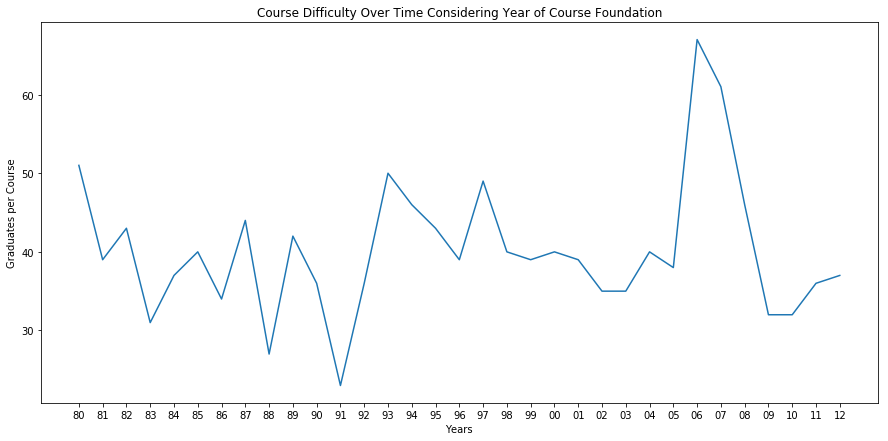

In [11]:
#Check above data as a plot
plt.figure(figsize=(15,7))
plt.plot(queryResult.index.str[-2:], queryResult['Grads_per_Course'])
plt.xlabel('Years')
plt.ylabel('Graduates per Course')
plt.title('Course Difficulty Over Time Considering Year of Course Foundation')

##### Brief explanation:

Just by looking at the data there doesn't seem to be a clear trend of increase over time, despite the spike of graduates per course in 2007 and 2008. Before discussing a statistical way to test whether or not there's a trend, two problems with this metric must be mentioned: 

- The way the metric is constructed using only 2018 data means that, if all courses got collectively easier or harder over time, no change would be revealed (since in 2018 all graduates would be collectively taking easier or harder courses, regardless of year of foundation).
- The metric takes into account the number of courses per year given the information of 2018, so again there's a survival bias in which only courses that still exist in 2018 are taken into account.

#### Testing whether or not there's a linear trend in the data

To check for a trend, we can calculate a Pearson correlation and associated p-value. Besides that, we can show the same data as a scatterplot with an associated line of best fit.



 The measure of linear association between the variables is: 

 0.1159 

 The p-value for such association is: 

 0.5208 




Text(0.5, 1.0, 'Course Difficulty Over Time Considering Year of Course Foundation')

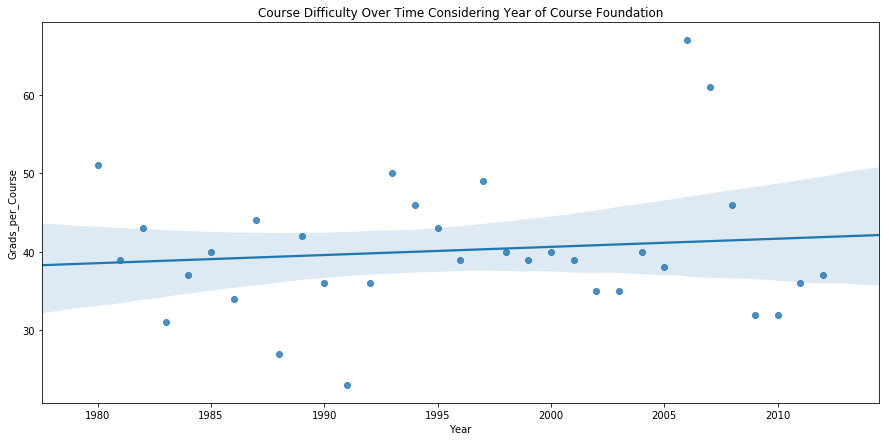

In [12]:
#Calculating Pearson's r
coefficient = pearsonr(queryResult.index.astype("int64"), queryResult['Grads_per_Course'])[0]
pvalue = pearsonr(queryResult.index.astype("int64"), queryResult['Grads_per_Course'])[1]

print(("\n"*2),"The measure of linear association between the variables is:", ("\n"*2), round(coefficient, 4), ("\n"*2),
     "The p-value for such association is:", ("\n"*2), round(pvalue,4), ("\n"*2))

#Plotting scatterplot with regression line
plt.figure(figsize=(15,7))
sns.regplot(queryResult.index.astype("int64").to_series(name = "Year"), queryResult['Grads_per_Course'])
plt.title('Course Difficulty Over Time Considering Year of Course Foundation')

##### Brief explanation:

As can be seen both from the scatterplot with the regression line's confidence interval and the results from Pearson's r, we found no evidence to suggest a relationship between course difficulty and year of course foundation (p > 0.05). In other words, time is not determining course difficulty level. 

Finally, another way to look at this lack of relationship is to check the slope of the regression line between Year of Foudnation and Graduates per Course, using Year as a predictor. Since the p-value for the correlation coefficient indicated that it was not different from zero, we should expect that the p-value for the slope of the regression line will also not be different from zero.

In [13]:
#Checking slope of the regression line using ordinary least squares algorithm

queryResult['Foundation_Year'] = queryResult.index.astype("int64")
model = smf.ols('Grads_per_Course ~ Foundation_Year', data = queryResult).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Grads_per_Course   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.4219
Date:                Thu, 23 Jan 2020   Prob (F-statistic):              0.521
Time:                        17:23:17   Log-Likelihood:                -117.38
No. Observations:                  33   AIC:                             238.8
Df Residuals:                      31   BIC:                             241.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -167.2598    319.413     

##### Brief explanation:

As expected, the Foundation Year was not significantly related to the number of Graduates per Course (p > 0.05), given that its coefficient value crossed through zero in the 95% confidence interval.

#### 5) Run a multiple linear regression to explain course evasion. Consider teacher quality as one of the explanatory variables.

To explain course evasion using linear regression, we will use the following variable from the "Students" table:

- TP_SITUACAO: indicates the situation of the student's affiliation to their Instituion. Of relevance to this work, number 4 indicates course abandonement. For each course, we will calculate the total number of students who abandoned it and divide that per total number of students, and this will be our target. We will name it "TAXA_ABANDONO" (evasion rate in portuguese).

We will use two more tables for this exercise: the "Courses" table and the "Teachers" table. Our goal is to choose a reasonable number of variables so we can properly explain the phenomenom we want to study. The chosen variables will be:

- "Courses" table:

 - QT_MATRICULA_TOTAL: total number of students in the course.
 - CO_CINE_ROTULO: a code that explains what is the type of course (Biology, Medicine, Law, etc.)
 - CO_UF: denotes the state in which the course is taking place.
 - TP_CATEGORIA_ADMINISTRATIVA: indicates the nature of the institution's funding.
 - TP_ORGANIZACAO_ACADEMICA: indicates the type of Higher Education Institution.
 - TP_MODALIDADE_ENSINO: indicates whether the course is face-to-face teaching or from-a-distance teaching.
 - IN_GRATUITO: indicates whether the course is free of charge for the student or if there's a monthly fee.
 - TP_ATRIBUTO_INGRESSO: indicates whether it's a regular course, a course for a general area of study where the student will have to choose a specialty afterwards or an interdisciplinary course.
 - NU_CARGA_HORARIA: the total amount of hours it takes to finish the course.
 - ANO_FUNDACAO: indicates year of course foundation, created from another variable DT_INICIO_FUNCIONAMENTO


- "Teachers" table:
 
 - TP_ESCOLARIDADE: indicates the education level of the teacher (master's, PhD, etc.)
 - TP_REGIME_TRABALHO: indicates what is the nature of the teacher's contract to the institution (full-time worker, party-time worker, etc.)
 - NU_IDADE: indicates the teacher's age.
 - TP_SITUACAO: indicates whether the teacher is working or in some other situation. We will consider only teachers which are working, which have a value of 1 for this variable.
 
Obs: the first three the variables from the "Teachers" table will be joined to the "Courses" table by aggregating them as averages. Despite the first two being categorical variables, they are represented as numbers with an ordinality associated to them, so the numerical averages should hold some information regarding average education level and nature of contract of the teachers.

In [120]:
#Creating query to run a multiple linear regression of course completion and other variables
query = """
    SELECT
    
    s.TAXA_ABANDONO,
    
    c.QT_MATRICULA_TOTAL, c.CO_CINE_ROTULO, c.CO_UF,
    c.TP_CATEGORIA_ADMINISTRATIVA, c.TP_ORGANIZACAO_ACADEMICA, c.TP_MODALIDADE_ENSINO, 
    c.IN_GRATUITO, c.TP_ATRIBUTO_INGRESSO, c.NU_CARGA_HORARIA, 
    SUBSTR(c.DT_INICIO_FUNCIONAMENTO, 7, 4) as ANO_FUNDACAO,
    
    d.TP_ESCOLARIDADE as ESCOLARIDADE_DOCENTE, d.TP_REGIME_TRABALHO as RT_DOCENTE, 
    d.NU_IDADE as IDADE_DOCENTE
     
    FROM

    Courses as c,

    (
        SELECT
    
            AVG(CAST (TP_ESCOLARIDADE AS FLOAT)) as TP_ESCOLARIDADE,
            AVG(CAST (TP_REGIME_TRABALHO AS FLOAT)) as TP_REGIME_TRABALHO,
            AVG(CAST (NU_IDADE AS FLOAT)) as NU_IDADE,
            CO_IES
        
        FROM Teachers
    
        WHERE TP_SITUACAO = 1
    
        GROUP BY CO_IES
    ) as d,
    
    (
        SELECT
            
            CO_CURSO,
            (CAST(SUM(CASE WHEN TP_SITUACAO = '4' THEN 1 ELSE 0 END) as FLOAT)/CAST(COUNT(TP_SITUACAO) as FLOAT)) as TAXA_ABANDONO
        
        FROM Students
        
        GROUP BY CO_CURSO
    ) as s
    
    WHERE 
    
    c.CO_CURSO = s.CO_CURSO AND
    c.CO_IES = d.CO_IES;
    """

#Querying the database and transfering result to pandas dataframe
queryResult = pd.read_sql_query(query, db)

#Displaying result
queryResult

,TAXA_ABANDONO,QT_MATRICULA_TOTAL,CO_CINE_ROTULO,CO_UF,TP_CATEGORIA_ADMINISTRATIVA,TP_ORGANIZACAO_ACADEMICA,TP_MODALIDADE_ENSINO,IN_GRATUITO,TP_ATRIBUTO_INGRESSO,NU_CARGA_HORARIA,ANO_FUNDACAO,ESCOLARIDADE_DOCENTE,RT_DOCENTE,IDADE_DOCENTE
0,0.017544,445,0421D01,51.0,1,1,1,1,0,3700,1952,4.391323,1.300687,43.029639
1,0.149228,344,0311E01,51.0,1,1,1,1,0,3000,1968,4.391323,1.300687,43.029639
2,0.037383,266,0732E01,51.0,1,1,1,1,0,3960,1968,4.391323,1.300687,43.029639
3,0.052061,326,0113P01,51.0,1,1,1,1,0,3545,1970,4.391323,1.300687,43.029639
4,0.164619,253,0923S01,51.0,1,1,1,1,0,3204,1970,4.391323,1.300687,43.029639
5,0.032037,321,0411C01,51.0,1,1,1,1,0,3024,1971,4.391323,1.300687,43.029639
6,0.093625,388,0811A04,51.0,1,1,1,1,0,4778,1974,4.391323,1.300687,43.029639
7,0.096033,372,0821E01,51.0,1,1,1,1,0,4364,1974,4.391323,1.300687,43.029639
8,0.017208,496,0912M01,51.0,1,1,1,1,0,8822,1978,4.391323,1.300687,43.029639
9,0.159892,458,0413A01,51.0,1,1,1,1,0,3416,1974,4.391323,1.300687,43.029639


#### Brief explanation:

Now that the dataframe with all variables of interested was created from the database, some data preprocessing will be needed before running the linear regression. In particular, the following code blocks will inspect the data, check for null values, perform imputations, label encode or dummy encode categorical variables, and check the correlation between variables. After that, we will run the linear regression.

In [121]:
#Seeing the nature of the data
queryResult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38256 entries, 0 to 38255
Data columns (total 14 columns):
TAXA_ABANDONO                  38256 non-null float64
QT_MATRICULA_TOTAL             38256 non-null int64
CO_CINE_ROTULO                 38256 non-null object
CO_UF                          35076 non-null float64
TP_CATEGORIA_ADMINISTRATIVA    38256 non-null int64
TP_ORGANIZACAO_ACADEMICA       38256 non-null int64
TP_MODALIDADE_ENSINO           38256 non-null int64
IN_GRATUITO                    38256 non-null int64
TP_ATRIBUTO_INGRESSO           38256 non-null int64
NU_CARGA_HORARIA               38256 non-null int64
ANO_FUNDACAO                   35668 non-null object
ESCOLARIDADE_DOCENTE           38256 non-null float64
RT_DOCENTE                     38256 non-null float64
IDADE_DOCENTE                  38256 non-null float64
dtypes: float64(5), int64(7), object(2)
memory usage: 4.1+ MB


In [122]:
#Checking null values
queryResult.isnull().sum()

TAXA_ABANDONO                     0
QT_MATRICULA_TOTAL                0
CO_CINE_ROTULO                    0
CO_UF                          3180
TP_CATEGORIA_ADMINISTRATIVA       0
TP_ORGANIZACAO_ACADEMICA          0
TP_MODALIDADE_ENSINO              0
IN_GRATUITO                       0
TP_ATRIBUTO_INGRESSO              0
NU_CARGA_HORARIA                  0
ANO_FUNDACAO                   2588
ESCOLARIDADE_DOCENTE              0
RT_DOCENTE                        0
IDADE_DOCENTE                     0
dtype: int64

##### Brief explanation:

There are 2 variables with null values. Each null value was individually inspected to understand why they contained nulls, and here is the explanation for each one:

- CO_UF: the null values for State all represent courses that are from-a-distance teaching. The following line of code will show that:

In [36]:
#Checking if all courses without a state code are courses from a distance
pd.Series.equals(queryResult[(queryResult['CO_UF'].isnull())], queryResult[(queryResult['TP_MODALIDADE_ENSINO'] == 2)])

True

- ANO_FUNDACAO: this here appears to simply be missing data. No clear pattern seems to emerge from the courses without a foundation date. The following line of code will show such courses:

In [123]:
#Checking courses without a foundation year
queryResult[(queryResult['ANO_FUNDACAO'].isnull())]

,TAXA_ABANDONO,QT_MATRICULA_TOTAL,CO_CINE_ROTULO,CO_UF,TP_CATEGORIA_ADMINISTRATIVA,TP_ORGANIZACAO_ACADEMICA,TP_MODALIDADE_ENSINO,IN_GRATUITO,TP_ATRIBUTO_INGRESSO,NU_CARGA_HORARIA,ANO_FUNDACAO,ESCOLARIDADE_DOCENTE,RT_DOCENTE,IDADE_DOCENTE
253,0.029412,45,0011A02,53.0,1,1,1,1,1,1000,None,4.857546,1.211213,47.224612
254,0.023529,165,0011A03,53.0,1,1,1,1,1,1000,None,4.857546,1.211213,47.224612
255,0.017241,79,0011A03,53.0,1,1,1,1,1,1000,None,4.857546,1.211213,47.224612
256,0.000000,39,0011A02,53.0,1,1,1,1,1,2400,None,4.857546,1.211213,47.224612
257,0.051948,68,0011A02,53.0,1,1,1,1,1,1000,None,4.857546,1.211213,47.224612
258,0.051095,62,0011A03,53.0,1,1,1,1,1,1000,None,4.857546,1.211213,47.224612
259,0.025974,71,0011A02,53.0,1,1,1,1,1,1000,None,4.857546,1.211213,47.224612
260,0.000000,14,0011A02,53.0,1,1,1,1,1,1000,None,4.857546,1.211213,47.224612
261,0.025126,90,0011A03,53.0,1,1,1,1,1,1000,None,4.857546,1.211213,47.224612
380,0.145540,174,0211C01,28.0,1,1,1,1,0,2730,None,4.607045,1.399009,43.572922


##### Continued explanation:

To handle the missing values from the State variable, we will impute a new state code that is not found among the existing states. To handle the missing values from the Date of Foundation variable, we will simply impute the mean year of foundation of the data

In [124]:
#Substituting missing values in CO_UF for a new non-existing state code
queryResult["CO_UF"].fillna(value = 10, inplace = True)

#Substituting missing values in ANO_FUNDACAO for mean value, then rounding the year numbers
from sklearn.impute import SimpleImputer

imp_Taxa = SimpleImputer()
queryResult["ANO_FUNDACAO"] = imp_Taxa.fit_transform(np.reshape(np.array(queryResult.ANO_FUNDACAO), (-1,1)))
queryResult["ANO_FUNDACAO"] = queryResult["ANO_FUNDACAO"].round().astype("int64")

#Displaying modified DataFrame
queryResult

,TAXA_ABANDONO,QT_MATRICULA_TOTAL,CO_CINE_ROTULO,CO_UF,TP_CATEGORIA_ADMINISTRATIVA,TP_ORGANIZACAO_ACADEMICA,TP_MODALIDADE_ENSINO,IN_GRATUITO,TP_ATRIBUTO_INGRESSO,NU_CARGA_HORARIA,ANO_FUNDACAO,ESCOLARIDADE_DOCENTE,RT_DOCENTE,IDADE_DOCENTE
0,0.017544,445,0421D01,51.0,1,1,1,1,0,3700,1952,4.391323,1.300687,43.029639
1,0.149228,344,0311E01,51.0,1,1,1,1,0,3000,1968,4.391323,1.300687,43.029639
2,0.037383,266,0732E01,51.0,1,1,1,1,0,3960,1968,4.391323,1.300687,43.029639
3,0.052061,326,0113P01,51.0,1,1,1,1,0,3545,1970,4.391323,1.300687,43.029639
4,0.164619,253,0923S01,51.0,1,1,1,1,0,3204,1970,4.391323,1.300687,43.029639
5,0.032037,321,0411C01,51.0,1,1,1,1,0,3024,1971,4.391323,1.300687,43.029639
6,0.093625,388,0811A04,51.0,1,1,1,1,0,4778,1974,4.391323,1.300687,43.029639
7,0.096033,372,0821E01,51.0,1,1,1,1,0,4364,1974,4.391323,1.300687,43.029639
8,0.017208,496,0912M01,51.0,1,1,1,1,0,8822,1978,4.391323,1.300687,43.029639
9,0.159892,458,0413A01,51.0,1,1,1,1,0,3416,1974,4.391323,1.300687,43.029639


In [125]:
#Checking null values (again) to see if changes worked
queryResult.isnull().sum()

TAXA_ABANDONO                  0
QT_MATRICULA_TOTAL             0
CO_CINE_ROTULO                 0
CO_UF                          0
TP_CATEGORIA_ADMINISTRATIVA    0
TP_ORGANIZACAO_ACADEMICA       0
TP_MODALIDADE_ENSINO           0
IN_GRATUITO                    0
TP_ATRIBUTO_INGRESSO           0
NU_CARGA_HORARIA               0
ANO_FUNDACAO                   0
ESCOLARIDADE_DOCENTE           0
RT_DOCENTE                     0
IDADE_DOCENTE                  0
dtype: int64

##### Brief explanation:

Now, to handle the categorical variables. There are two categorical variables with high cardinality (over 12 levels): CO_CINE_ROTULO and CO_UF. To handle such high-cardinality variables, we will group their levels together. In CO_CINE_ROTULO, the first 2 digits of the variable indicate the general domain of knowledge, varying from 00 to 10 (11 levels). This will be our new grouping. For the state, we will group the variables in the five brazilian regions (North, Northeast, Middle-West, Southeast and South, adding another region for the state value we invented). We will also change the name of this last variable from CO_UF to REGIAO.

Then, after having just categorical variables with fewer levels, we will use dummy-encoding on all of the variables with more than 2 levels. 

OBS1: the variable TP_MODALIDADE_ENSINO has just two levels, but they are coded with 1s and 2s. We will change this code to 1s and 0s.

OBS2: the variable TP_ATRIBUTO_INGRESSO should have only 3 levels (as per the dictionary provided by INEP), but it has 4. We will group the 2 smallest levels so as to still be able to interpret this variable.

In [126]:
#Modifying CO_CINE_ROTULO variable
queryResult['CO_CINE_ROTULO'] = queryResult['CO_CINE_ROTULO'].str[0:2].astype("int64")

#Modifying CO_UF variable
my_dict = {10: "ESP",
           11: "NO", 12: "NO", 13: "NO", 14: "NO", 15: "NO", 16: "NO", 17: "NO",
           21: "NE", 22: "NE", 23: "NE", 24: "NE", 25: "NE", 26: "NE", 27: "NE", 28: "NE", 29: "NE",
           31: "SE", 32: "SE", 33: "SE", 35: "SE",
           41: "SU", 42: "SU", 43: "SU",
           50: "CO", 51: "CO", 52: "CO", 53: "CO"}

queryResult.rename(columns = {"CO_UF": "REGIAO"}, inplace = True)
queryResult['REGIAO'] = queryResult['REGIAO'].map(my_dict)

#Changing TP_MODALIDADE_ENSINO to 1s and 0s instead of 1s and 2s
queryResult["TP_MODALIDADE_ENSINO"] = queryResult["TP_MODALIDADE_ENSINO"].map({2: 0, 1: 1})

#Changing TP_ATRIBUTO_INGRESSO to group smallest levels
queryResult["TP_ATRIBUTO_INGRESSO"] = queryResult["TP_ATRIBUTO_INGRESSO"].map({0: 0, 1: 1, 2: 2, 3: 2})

#Displaying results
queryResult

,TAXA_ABANDONO,QT_MATRICULA_TOTAL,CO_CINE_ROTULO,REGIAO,TP_CATEGORIA_ADMINISTRATIVA,TP_ORGANIZACAO_ACADEMICA,TP_MODALIDADE_ENSINO,IN_GRATUITO,TP_ATRIBUTO_INGRESSO,NU_CARGA_HORARIA,ANO_FUNDACAO,ESCOLARIDADE_DOCENTE,RT_DOCENTE,IDADE_DOCENTE
0,0.017544,445,4,CO,1,1,1,1,0,3700,1952,4.391323,1.300687,43.029639
1,0.149228,344,3,CO,1,1,1,1,0,3000,1968,4.391323,1.300687,43.029639
2,0.037383,266,7,CO,1,1,1,1,0,3960,1968,4.391323,1.300687,43.029639
3,0.052061,326,1,CO,1,1,1,1,0,3545,1970,4.391323,1.300687,43.029639
4,0.164619,253,9,CO,1,1,1,1,0,3204,1970,4.391323,1.300687,43.029639
5,0.032037,321,4,CO,1,1,1,1,0,3024,1971,4.391323,1.300687,43.029639
6,0.093625,388,8,CO,1,1,1,1,0,4778,1974,4.391323,1.300687,43.029639
7,0.096033,372,8,CO,1,1,1,1,0,4364,1974,4.391323,1.300687,43.029639
8,0.017208,496,9,CO,1,1,1,1,0,8822,1978,4.391323,1.300687,43.029639
9,0.159892,458,4,CO,1,1,1,1,0,3416,1974,4.391323,1.300687,43.029639


In [127]:
#Dummy-encoding the categorical variables with more than 2 levels

cols_dummies = ['CO_CINE_ROTULO', 'REGIAO', 'TP_CATEGORIA_ADMINISTRATIVA', 'TP_ORGANIZACAO_ACADEMICA', 'TP_ATRIBUTO_INGRESSO']
queryResult = pd.get_dummies(queryResult, columns = cols_dummies, drop_first = True)

#Displaying results
queryResult

,TAXA_ABANDONO,QT_MATRICULA_TOTAL,TP_MODALIDADE_ENSINO,IN_GRATUITO,NU_CARGA_HORARIA,ANO_FUNDACAO,ESCOLARIDADE_DOCENTE,RT_DOCENTE,IDADE_DOCENTE,CO_CINE_ROTULO_1,...,TP_CATEGORIA_ADMINISTRATIVA_3,TP_CATEGORIA_ADMINISTRATIVA_4,TP_CATEGORIA_ADMINISTRATIVA_5,TP_CATEGORIA_ADMINISTRATIVA_7,TP_ORGANIZACAO_ACADEMICA_2,TP_ORGANIZACAO_ACADEMICA_3,TP_ORGANIZACAO_ACADEMICA_4,TP_ORGANIZACAO_ACADEMICA_5,TP_ATRIBUTO_INGRESSO_1,TP_ATRIBUTO_INGRESSO_2
0,0.017544,445,1,1,3700,1952,4.391323,1.300687,43.029639,0,...,0,0,0,0,0,0,0,0,0,0
1,0.149228,344,1,1,3000,1968,4.391323,1.300687,43.029639,0,...,0,0,0,0,0,0,0,0,0,0
2,0.037383,266,1,1,3960,1968,4.391323,1.300687,43.029639,0,...,0,0,0,0,0,0,0,0,0,0
3,0.052061,326,1,1,3545,1970,4.391323,1.300687,43.029639,1,...,0,0,0,0,0,0,0,0,0,0
4,0.164619,253,1,1,3204,1970,4.391323,1.300687,43.029639,0,...,0,0,0,0,0,0,0,0,0,0
5,0.032037,321,1,1,3024,1971,4.391323,1.300687,43.029639,0,...,0,0,0,0,0,0,0,0,0,0
6,0.093625,388,1,1,4778,1974,4.391323,1.300687,43.029639,0,...,0,0,0,0,0,0,0,0,0,0
7,0.096033,372,1,1,4364,1974,4.391323,1.300687,43.029639,0,...,0,0,0,0,0,0,0,0,0,0
8,0.017208,496,1,1,8822,1978,4.391323,1.300687,43.029639,0,...,0,0,0,0,0,0,0,0,0,0
9,0.159892,458,1,1,3416,1974,4.391323,1.300687,43.029639,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
#Checking info on the data again after manipulations
queryResult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38256 entries, 0 to 38255
Data columns (total 35 columns):
TAXA_ABANDONO                    38256 non-null float64
QT_MATRICULA_TOTAL               38256 non-null int64
TP_MODALIDADE_ENSINO             38256 non-null int64
IN_GRATUITO                      38256 non-null int64
NU_CARGA_HORARIA                 38256 non-null int64
ANO_FUNDACAO                     38256 non-null int64
ESCOLARIDADE_DOCENTE             38256 non-null float64
RT_DOCENTE                       38256 non-null float64
IDADE_DOCENTE                    38256 non-null float64
CO_CINE_ROTULO_1                 38256 non-null uint8
CO_CINE_ROTULO_2                 38256 non-null uint8
CO_CINE_ROTULO_3                 38256 non-null uint8
CO_CINE_ROTULO_4                 38256 non-null uint8
CO_CINE_ROTULO_5                 38256 non-null uint8
CO_CINE_ROTULO_6                 38256 non-null uint8
CO_CINE_ROTULO_7                 38256 non-null uint8
CO_CINE_ROTULO_8   

##### Brief explanation:

Now that all missing values and categorical variables were handled, we can inspect the correlation between variables and run a linear regression.

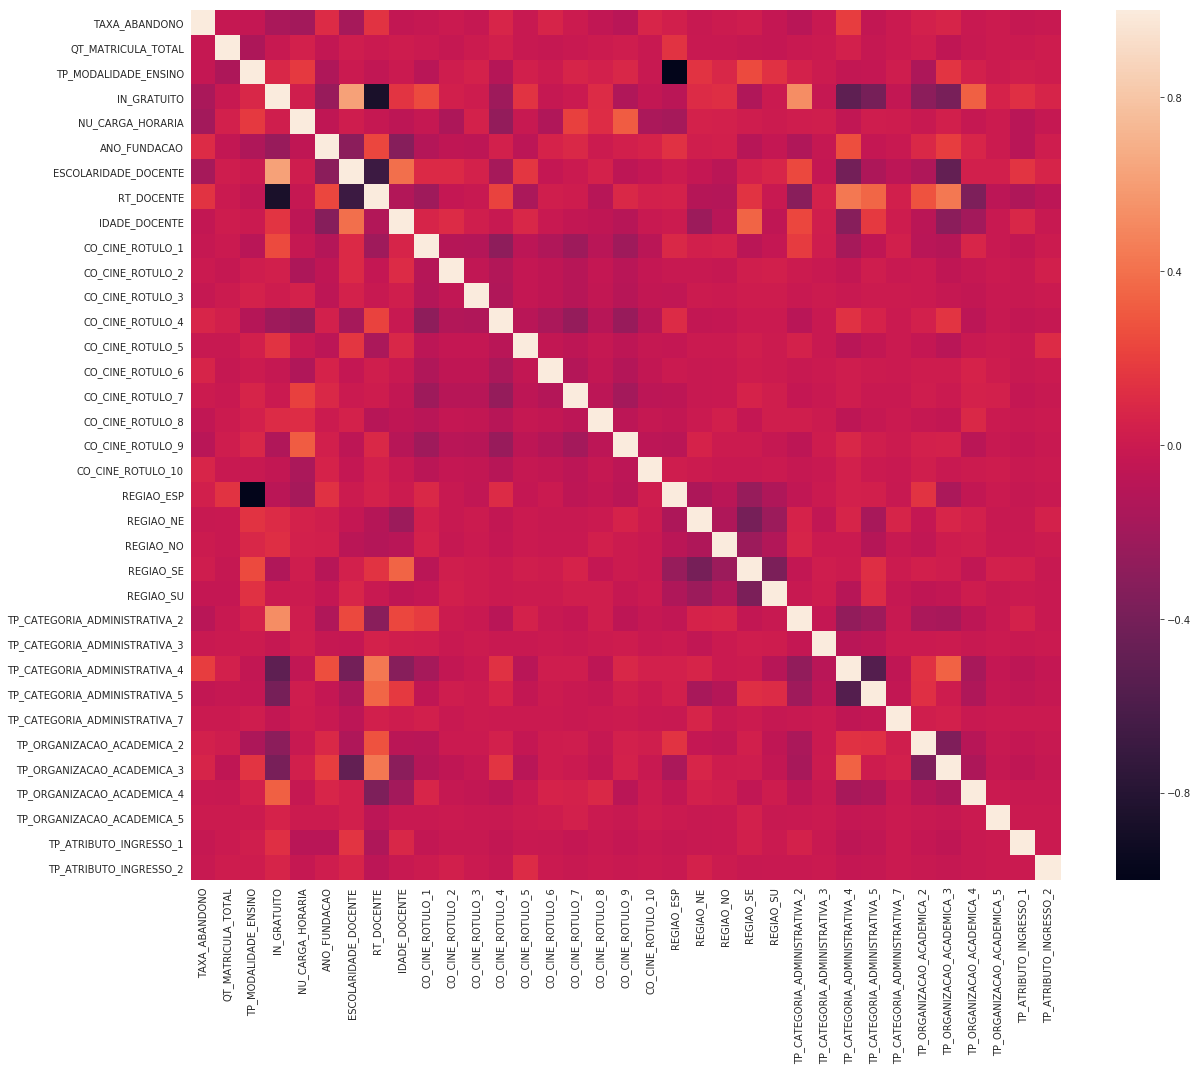

In [129]:
#Checking correlations between variables using a heatmap
corr = queryResult.corr()

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (20, 16));
    
    sns.heatmap(
        corr,
        ax = ax,
        square = True
    );

##### Brief explanation:

Some variables are showing multicollinearity (like RT_DOCENTE and IN_GRATUITO), but none seems particularly correlated with our dependant variable (the evasion rate). We will run the linear regression as is before making any further changes.

In [130]:
#Running the regression (at last)

my_formula = """TAXA_ABANDONO ~ QT_MATRICULA_TOTAL + TP_MODALIDADE_ENSINO +
       IN_GRATUITO + NU_CARGA_HORARIA + ANO_FUNDACAO +
       ESCOLARIDADE_DOCENTE + RT_DOCENTE + IDADE_DOCENTE +
       CO_CINE_ROTULO_1 + CO_CINE_ROTULO_2 + CO_CINE_ROTULO_3 +
       CO_CINE_ROTULO_4 + CO_CINE_ROTULO_5 + CO_CINE_ROTULO_6 +
       CO_CINE_ROTULO_7 + CO_CINE_ROTULO_8 + CO_CINE_ROTULO_9 +
       CO_CINE_ROTULO_10 + REGIAO_ESP + REGIAO_NE + REGIAO_NO +
       REGIAO_SE + REGIAO_SU + TP_CATEGORIA_ADMINISTRATIVA_2 +
       TP_CATEGORIA_ADMINISTRATIVA_3 + TP_CATEGORIA_ADMINISTRATIVA_4 +
       TP_CATEGORIA_ADMINISTRATIVA_5 + TP_CATEGORIA_ADMINISTRATIVA_7 +
       TP_ORGANIZACAO_ACADEMICA_2 + TP_ORGANIZACAO_ACADEMICA_3 +
       TP_ORGANIZACAO_ACADEMICA_4 + TP_ORGANIZACAO_ACADEMICA_5 +
       TP_ATRIBUTO_INGRESSO_1 + TP_ATRIBUTO_INGRESSO_2"""
model = smf.ols(formula = my_formula, data = queryResult).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          TAXA_ABANDONO   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     122.4
Date:                Fri, 24 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:05:43   Log-Likelihood:                 13051.
No. Observations:               38256   AIC:                        -2.604e+04
Df Residuals:                   38223   BIC:                        -2.575e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

##### Brief explanation:

Since we are seeking explanatory power, not model performance, it's better to run the analysis again without the variables that had p-values below 0.05 to facilitate our view of the interpretation. Besides that, it's also interesting to drop at least "IN_GRATUITO" and "TP_MODALIDADE_ENSINO" from our regression as well, since they showed strong colinearity with other variables. Finally, we should also standardize all measures (centering the mean on zero) so that also helps in interpreting the results.

In [131]:
#Dropping low-significance variables, including the ones with high colinearity
cols_to_drop = ["IN_GRATUITO", "TP_MODALIDADE_ENSINO", "CO_CINE_ROTULO_1",
               "CO_CINE_ROTULO_4", "CO_CINE_ROTULO_5", "CO_CINE_ROTULO_6",
               "CO_CINE_ROTULO_7", "REGIAO_NO", "REGIAO_SE", "TP_CATEGORIA_ADMINISTRATIVA_2",
               "TP_CATEGORIA_ADMINISTRATIVA_7", "TP_ORGANIZACAO_ACADEMICA_4", "TP_ORGANIZACAO_ACADEMICA_5",
               "TP_ATRIBUTO_INGRESSO_2"]
queryResultMod = queryResult.drop(columns = cols_to_drop)

#Standardizing non-binary columns around a mean of zero
queryResultMod = queryResultMod.apply(lambda x: x if (np.array_equal(x.unique(), (0,1)) or np.array_equal(x.unique(),
                                                                                                       (1,0))) else (x - x.mean())/x.std())

In [132]:
#Running regression again with relevant variables
my_formula = """TAXA_ABANDONO ~ QT_MATRICULA_TOTAL +
       NU_CARGA_HORARIA + ANO_FUNDACAO +
       ESCOLARIDADE_DOCENTE + RT_DOCENTE + IDADE_DOCENTE +
       CO_CINE_ROTULO_2 + CO_CINE_ROTULO_3 +
       CO_CINE_ROTULO_8 + CO_CINE_ROTULO_9 +
       CO_CINE_ROTULO_10 + REGIAO_ESP + REGIAO_NE + REGIAO_SU +
       TP_CATEGORIA_ADMINISTRATIVA_3 + TP_CATEGORIA_ADMINISTRATIVA_4 +
       TP_CATEGORIA_ADMINISTRATIVA_5 +
       TP_ORGANIZACAO_ACADEMICA_2 + TP_ORGANIZACAO_ACADEMICA_3 +
       TP_ATRIBUTO_INGRESSO_1"""
model = smf.ols(formula = my_formula, data = queryResultMod).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          TAXA_ABANDONO   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     192.2
Date:                Fri, 24 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:06:05   Log-Likelihood:                -52450.
No. Observations:               38256   AIC:                         1.049e+05
Df Residuals:                   38235   BIC:                         1.051e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

##### Brief explanation:

The low R² indicates that our linear regression model is doing a poor job in explaining the variation in our target variable (evasion rate), meaning it probably needs improvement. One possible way to fix that is to combine and modify variables (feature engineering) to find a more responsive model, but our goal here was just to check which variables seem to be relevant when trying to explain the variation in student's evasion rate. Some conclusions we can take from this:

- As number of hours in a course increases, evasion rate decreases (variable NU_CARGA_HORARIA).
- Courses that were founded more recently have a higher evasion rate (variable ANO_FUNDACAO).
- In relation to courses classified as "Basic Programs" (our ommitted dummy variable in CO_CINE_ROTULO), courses in arts and humanities, social sciences, journalism, health, veterinary and agriculture all have smaller evasion rates, while courses in the area of services have greater evasion rates.
- In relation to courses offered in the Middle-West region (our ommitted dummy variable in REGION), courses in the Northeast, South and from-a-distance courses all have smaller evasion rates.
- Finally, when it comes to teachers, higher education level is correlated with lower evasion rates, while bein older is correlated with higher evasion rates.

Since we standardize the data, the way to interpret the coefficients is: they represent the amount of standard deviations that the evasion rate will change given a change in 1 standard deviation in the explanatory variable. So, for example, in the case of teacher's education: for each one standard deviation increase in teacher's education the evasion rate drops in 0.1364 standard deviations.

#### 6) Which are the courses with most growth per region? And which are the courses with most decline? How to explain that?

Once again, to solve this problem, we will perform a query on the database. Since we are limited to only 2018 data, we will create a metric that evaluates course growth or decline by looking at the Students table, that tells the year a student got into the course. With this information we can, for each course, map the amount of students that entered in a particular year (notice that students that abandoned the course before 2018 will not be represented, a slight bias in our sample). Armed with that we can, for each course, calculate the change in number of students from one year to another, and then take an average of such change. This average will be our metric for course growth or decline, and we will call it DIF_CRESCIMENTO (growth differential). The bigger the DIF_CRESCIMENTO, the more students got into the course along the years, and the smaller (the more negative) the less students got into the course. For our metric to be valid, we have to consider only students who entered from 2015 forward, otherwise we risk counting years where students might have already finish their courses.

We will use the "Students" table with the following variables:

- CO_UF: it denotes the state code. In Brazil, there are five great regions composed of different states: the Norht, Northeast, Middle-West, Southeast and South.
- DT_INGRESSO_CURSO: indicates the date in which the student entered in his course, we will use just the year and called it ANO_ENTRADA. This variable will not be included in our final DataFrame, but it will be used in our subqueries to calculate DIF_CRESCIMENTO.
- CO_CURSO: unique code that identifies the course.
- NO_CURSO: represents the course's name (in portuguese).

In [22]:
#Creating query to check how many students are finishing their courses in 2018 given the year of entrance
query = """

    SELECT
    
    CO_UF, NO_CURSO, CO_CURSO, AVG(ALUNOS - ALUNOS_ANT) as DIF_CRESCIMENTO
    
    FROM
    
    (

        SELECT
    
        CO_UF, NO_CURSO, CO_CURSO, ANO_ENTRADA, ALUNOS, 
        LAG(ALUNOS) OVER (PARTITION BY CO_CURSO ORDER BY ANO_ENTRADA) as ALUNOS_ANT

        FROM
    
        (
            SELECT
    
            c.CO_UF, c.NO_CURSO, s.CO_CURSO, CAST(SUBSTR(s.DT_INGRESSO_CURSO, 6, 4) as INT) as ANO_ENTRADA,
            COUNT(CAST(SUBSTR(s.DT_INGRESSO_CURSO, 6, 4) as INT)) as ALUNOS
    
            FROM Students as s, Courses as c
    
            WHERE ANO_ENTRADA >= 2015 AND ANO_ENTRADA <= 2018 AND s.CO_CURSO = c.CO_CURSO
    
            GROUP BY s.CO_CURSO, ANO_ENTRADA
        )

    )
    
    GROUP BY CO_CURSO
    """

#Querying the database and transfering result to pandas dataframe
queryResult = pd.read_sql_query(query, db)

#Displaying result
queryResult

,CO_UF,NO_CURSO,CO_CURSO,DIF_CRESCIMENTO
0,51.0,DIREITO,1,2.000000
1,51.0,CIÊNCIAS ECONÔMICAS,2,6.666667
2,51.0,ENGENHARIA CIVIL,3,1.000000
3,51.0,PEDAGOGIA,6,-0.333333
4,51.0,SERVIÇO SOCIAL,7,4.000000
5,51.0,CIÊNCIAS CONTÁBEIS,8,2.000000
6,51.0,AGRONOMIA,9,2.000000
7,51.0,ENGENHARIA FLORESTAL,10,2.333333
8,51.0,MEDICINA,12,-0.333333
9,51.0,ADMINISTRAÇÃO,13,-2.333333


##### Brief explanation:

Now, armed with the DataFrame above, it's possible to group courses per region and get the ones with the largest positive or negative DIF_CRESCIMENTO.

In [23]:
#Substituting states' number code per region acronym and renaming the states column
my_dict = {11: "NO", 12: "NO", 13: "NO", 14: "NO", 15: "NO", 16: "NO", 17: "NO",
          21: "NE", 22: "NE", 23: "NE", 24: "NE", 25: "NE", 26: "NE", 27: "NE", 28: "NE", 29: "NE",
          31: "SE", 32: "SE", 33: "SE", 35: "SE",
          41: "SU", 42: "SU", 43: "SU",
          50: "CO", 51: "CO", 52: "CO", 53: "CO"}

queryResult.rename(columns = {"CO_UF": "REGIAO"}, inplace = True)
queryResult['REGIAO'] = queryResult['REGIAO'].map(my_dict)

In [24]:
#Displaying courses with most growth per region
most_growth = queryResult.groupby(['REGIAO'])['NO_CURSO','DIF_CRESCIMENTO'].apply(lambda x: x.nlargest(10, columns = ['DIF_CRESCIMENTO']))

most_growth

NO_CURSO  DIF_CRESCIMENTO
REGIAO                                                                   
CO     31232                                  ENFERMAGEM       246.000000
       3254                                      DIREITO       245.666667
       36556                            ABI - ENGENHARIA       169.000000
       4808                                      DIREITO       161.666667
       21518                                  ENFERMAGEM       151.333333
       9634                   GESTÃO DE RECURSOS HUMANOS       147.666667
       15203                                     DIREITO       127.000000
       33625                                  RADIOLOGIA       127.000000
       30856                                  PSICOLOGIA       121.000000
       3725                                   ENFERMAGEM       118.666667
NE     36740                                     DIREITO       266.666667
       28527                        ESTÉTICA E COSMÉTICA       241.500000
       30588                                    FARMÁCIA       221.500000
       29388                             EDUCAÇÃO FÍSICA       221.333333
       24846                                   PEDAGOGIA       215.666667
       17441    INTERDISCIPLINAR EM CIÊNCIA E TECNOLOGIA       207.333333
       29720                                  PSICOLOGIA       205.000000
       33541                             EDUCAÇÃO FÍSICA       200.000000
       3148                                      DIREITO       193.333333
       32250                                    NUTRIÇÃO       192.000000
NO     9749                                      DIREITO       437.666667
       33034  GESTÃO DE SERVIÇOS JUDICIÁRIOS E NOTARIAIS       249.000000
       13437                                     DIREITO       196.000000
       35445                  GESTÃO DE RECURSOS HUMANOS       181.000000
       24009                               ADMINISTRAÇÃO       167.500000
       25298                                     DIREITO       162.000000
       32090                  LETRAS - LÍNGUA PORTUGUESA       159.000000
       29406                                   PEDAGOGIA       149.000000
       31468                                  COMPUTAÇÃO       148.000000
       30938                              SERVIÇO SOCIAL       142.000000
SE     5719                                   PSICOLOGIA       933.000000
       1464                                      DIREITO       732.000000
       6796                                       LETRAS       707.500000
       37080                                  PSICOLOGIA       650.000000
       9467                                      DIREITO       433.333333
       34479                        ESTÉTICA E COSMÉTICA       406.000000
       6048                                   ENFERMAGEM       403.666667
       37078                                     DIREITO       399.000000
       10324                                     DIREITO       368.333333
       1057                                      DIREITO       340.666667
SU     30677                        MEDICINA VETERINÁRIA       183.000000
       34037                             EDUCAÇÃO FÍSICA       171.000000
       31472                                  PSICOLOGIA       146.000000
       29542                                  ENFERMAGEM       117.000000
       29544                                  PSICOLOGIA       117.000000
       19648                               ADMINISTRAÇÃO       109.000000
       12004                                     DIREITO       102.666667
       32500                      ENGENHARIA DE PRODUÇÃO       101.000000
       29566                        ESTÉTICA E COSMÉTICA        98.000000
       19651                          CIÊNCIAS CONTÁBEIS        95.000000

In [25]:
#Checking for courses with most occurrences of growth:
most_growth['NO_CURSO'].value_counts()

DIREITO                                       14
PSICOLOGIA                                     6
ENFERMAGEM                                     5
ESTÉTICA E COSMÉTICA                           3
EDUCAÇÃO FÍSICA                                3
GESTÃO DE RECURSOS HUMANOS                     2
ADMINISTRAÇÃO                                  2
PEDAGOGIA                                      2
LETRAS - LÍNGUA PORTUGUESA                     1
GESTÃO DE SERVIÇOS JUDICIÁRIOS E NOTARIAIS     1
SERVIÇO SOCIAL                                 1
RADIOLOGIA                                     1
ENGENHARIA DE PRODUÇÃO                         1
LETRAS                                         1
NUTRIÇÃO                                       1
INTERDISCIPLINAR EM CIÊNCIA E TECNOLOGIA       1
COMPUTAÇÃO                                     1
ABI - ENGENHARIA                               1
CIÊNCIAS CONTÁBEIS                             1
FARMÁCIA                                       1
MEDICINA VETERINÁRIA

In [26]:
#Displaying courses with most decline per region
most_decline = queryResult.groupby(['REGIAO'])['NO_CURSO','DIF_CRESCIMENTO'].apply(lambda x: x.nsmallest(10, columns = ['DIF_CRESCIMENTO']))

most_decline

NO_CURSO  \
REGIAO                                                            
CO     3459                                             DIREITO   
       23366                                   ENGENHARIA CIVIL   
       22704                                            DIREITO   
       25457                                   ENGENHARIA CIVIL   
       1518                                             DIREITO   
       16842                                   ENGENHARIA CIVIL   
       3535                                             DIREITO   
       25296                                   ENGENHARIA CIVIL   
       26533                                   ENGENHARIA CIVIL   
       36552                                            DIREITO   
NE     29696                                          LOGÍSTICA   
       29697                             SISTEMAS PARA INTERNET   
       16021                                           NUTRIÇÃO   
       1417                                             DIREITO   
       12914                                          PEDAGOGIA   
       7135                                             DIREITO   
       9443                                             DIREITO   
       16009                                    EDUCAÇÃO FÍSICA   
       25183                                          PEDAGOGIA   
       26296                                      ADMINISTRAÇÃO   
NO     33406                                           NUTRIÇÃO   
       25586                                          PEDAGOGIA   
       30665                                         PSICOLOGIA   
       32241                               ESTÉTICA E COSMÉTICA   
       15153                                         ENFERMAGEM   
       12331                                         ENFERMAGEM   
       15603                                   ENGENHARIA CIVIL   
       30464   EDUCAÇÃO DO CAMPO - CIÊNCIAS AGRÁRIAS E BIOLOGIA   
       2143                                           GEOGRAFIA   
       29754                                         PSICOLOGIA   
SE     19451                                 LETRAS - PORTUGUÊS   
       30180                                 CIÊNCIAS CONTÁBEIS   
       29321                                ENGENHARIA MECÂNICA   
       19695                                         PSICOLOGIA   
       903                                     ENGENHARIA CIVIL   
       32729                                         ENFERMAGEM   
       1211                                    ENGENHARIA CIVIL   
       29513                             ENGENHARIA DE PRODUÇÃO   
       1465                                          PSICOLOGIA   
       32208                                           MEDICINA   
SU     4217                                  CIÊNCIAS CONTÁBEIS   
       4634                                             DIREITO   
       31716                                         FOTOGRAFIA   
       33530                               MEDICINA VETERINÁRIA   
       37071  LETRAS - LÍNGUA INGLESA E RESPECTIVAS LITERATURAS   
       3923                                MEDICINA VETERINÁRIA   
       30723                                   ENGENHARIA CIVIL   
       26210                                       FISIOTERAPIA   
       5242                                 ENGENHARIA MECÂNICA   
       32830                              ADMINISTRAÇÃO PÚBLICA   

              DIF_CRESCIMENTO  
REGIAO                         
CO     3459       -148.000000  
       23366       -98.666667  
       22704       -98.000000  
       25457       -89.333333  
       1518        -84.000000  
       16842       -81.666667  
       3535        -75.333333  
       25296       -71.666667  
       26533       -71.000000  
       36552       -70.666667  
NE     29696      -210.000000  
       29697      -203.000000  
       16021      -190.333333  
       1417       -182.666667  
       12914      -144.000000  
       7135       -115.333

In [21]:
#Checking for courses with most occurrences of decline:
most_decline['NO_CURSO'].value_counts()

ENGENHARIA CIVIL                                     9
DIREITO                                              9
PSICOLOGIA                                           4
PEDAGOGIA                                            3
ENFERMAGEM                                           3
MEDICINA VETERINÁRIA                                 2
CIÊNCIAS CONTÁBEIS                                   2
ENGENHARIA MECÂNICA                                  2
NUTRIÇÃO                                             2
ADMINISTRAÇÃO PÚBLICA                                1
FOTOGRAFIA                                           1
LETRAS - LÍNGUA INGLESA E RESPECTIVAS LITERATURAS    1
ESTÉTICA E COSMÉTICA                                 1
ENGENHARIA DE PRODUÇÃO                               1
EDUCAÇÃO FÍSICA                                      1
FISIOTERAPIA                                         1
SISTEMAS PARA INTERNET                               1
GEOGRAFIA                                            1
ADMINISTRA

##### Brief explanation:

Given our index of growth, the courses that seem to be experiencing the most amount of growth are Law courses, particularly so in the Southeast (followed by psychology and nursing courses). The courses that seem to be experiencing the most decline present a more mixed picture. The exception seems to be the Middle-West region which has consistent decline for both law and engineering. 

In short, law courses seem to experience the greatest rise (despite some number of them also being on most decline), while engineering is tied with law leading the courses with the most decline. 

#### 7) Create a new variable "astrological sign" and check whether or not such variable is correlated with the probability of finishing the course.

In order to do that, we must first update our database. Specifically, we will add the variable "SIGNO" (sign in portuguese) to the "Students" table. After that, we will query the database to obtain a dataframe and check for an association between astrological sign and probability of finishing a course using Cramér's V one more time. To estimate such probability of finishing a course, we will simply divide the number of graduating students per the total number of students for each astrological sign. As already mentioned, we will use the "Students" table, alongside the following variables:

- SIGNO: variable that we created, indicating astrological sign of student.
- NU_DIA_NASCIMENTO: variable that indicates the day the student was born, used to create the astrological sign variable.
- NU_MES_NASCIMENTO: variable that indicates the month the student was born, used to create the astrological sign variable.
- IN_CONCLUINTE: already explained in question 4, a variable that tell whether or not the student is finishing their course in 2018.

In [ ]:
#Updating the students table to add astrological sign variable

cur = db.cursor()

cur.execute(
    """
    ALTER TABLE Students
    ADD SIGNO varchar(15);
    """
)

cur.execute(
    """
    UPDATE Students

    SET SIGNO = 
    (
        CASE
            WHEN (NU_DIA_NASCIMENTO >= 22 AND NU_MES_NASCIMENTO = 12) OR (NU_DIA_NASCIMENTO <= 20 AND NU_MES_NASCIMENTO = 1)
                THEN
                    'Capricórnio'
            WHEN (NU_DIA_NASCIMENTO >= 21 AND NU_MES_NASCIMENTO = 1) OR (NU_DIA_NASCIMENTO <= 19 AND NU_MES_NASCIMENTO = 2) 
                THEN
                    'Aquário'
            WHEN (NU_DIA_NASCIMENTO >= 20 AND NU_MES_NASCIMENTO = 2) OR (NU_DIA_NASCIMENTO <= 20 AND NU_MES_NASCIMENTO = 3)
                THEN
                    'Peixes'
            WHEN (NU_DIA_NASCIMENTO >= 21 AND NU_MES_NASCIMENTO = 3) OR (NU_DIA_NASCIMENTO <= 20 AND NU_MES_NASCIMENTO = 4)
                THEN
                    'Áries'
            WHEN (NU_DIA_NASCIMENTO >= 21 AND NU_MES_NASCIMENTO = 4) OR (NU_DIA_NASCIMENTO <= 20 AND NU_MES_NASCIMENTO = 5)
                THEN
                    'Touro'
            WHEN (NU_DIA_NASCIMENTO >= 21 AND NU_MES_NASCIMENTO = 5) OR (NU_DIA_NASCIMENTO <= 20 AND NU_MES_NASCIMENTO = 6)
                THEN
                    'Gêmeos'
            WHEN (NU_DIA_NASCIMENTO >= 21 AND NU_MES_NASCIMENTO = 6) OR (NU_DIA_NASCIMENTO <= 21 AND NU_MES_NASCIMENTO = 7)
                THEN
                    'Câncer'
            WHEN (NU_DIA_NASCIMENTO >= 22 AND NU_MES_NASCIMENTO = 7) OR (NU_DIA_NASCIMENTO <= 22 AND NU_MES_NASCIMENTO = 8) 
                THEN
                    'Leão'
            WHEN (NU_DIA_NASCIMENTO >= 23 AND NU_MES_NASCIMENTO = 8) OR (NU_DIA_NASCIMENTO <= 22 AND NU_MES_NASCIMENTO = 9)
                THEN
                    'Virgem'
            WHEN (NU_DIA_NASCIMENTO >= 23 AND NU_MES_NASCIMENTO = 9) OR (NU_DIA_NASCIMENTO <= 22 AND NU_MES_NASCIMENTO = 10)
                THEN
                    'Libra'
            WHEN (NU_DIA_NASCIMENTO >= 23 AND NU_MES_NASCIMENTO = 10) OR (NU_DIA_NASCIMENTO <= 21 AND NU_MES_NASCIMENTO = 11)
                THEN
                    'Escorpião'
            WHEN (NU_DIA_NASCIMENTO >= 22 AND NU_MES_NASCIMENTO = 11) OR (NU_DIA_NASCIMENTO <= 21 AND NU_MES_NASCIMENTO = 12)
                THEN
                    'Sagitário'
        END
    );"""
)

db.commit()

In [3]:
#Creating query to calculate probability of finishing a course given astrological sign
query = """
    SELECT
    
    SIGNO as Sign, 
    
    COUNT(CASE WHEN IN_CONCLUINTE = 1 THEN 1 END) AS Graduates,
    
    COUNT(CASE WHEN IN_CONCLUINTE = 0 THEN 1 END) AS Others,
    
    COUNT(IN_CONCLUINTE) as Total,
    
    (CAST(COUNT(CASE WHEN IN_CONCLUINTE = 1 THEN 1 END) as FLOAT)/CAST(COUNT(IN_CONCLUINTE) as FLOAT)) as Conclusion_Probability
    
    FROM Students
    
    GROUP BY Sign;
    """

#Querying the database and transfering result to pandas dataframe, then changing index
queryResult = pd.read_sql_query(query, db)
queryResult.set_index('Sign', inplace = True)

#Displaying result
queryResult

,Graduates,Others,Total,Conclusion_Probability
Sign,,,,
Aquário,101934,878460,980394,0.103972
Capricórnio,99479,848676,948155,0.104918
Câncer,108988,919454,1028442,0.105974
Escorpião,99240,847375,946615,0.104837
Gêmeos,109806,932785,1042591,0.105320
Leão,108957,927046,1036003,0.105171
Libra,103671,878950,982621,0.105505
Peixes,105782,906488,1012270,0.104500
Sagitário,99066,844500,943566,0.104991


##### Brief explanation:

Given the results displayed in the dataframe alone, it seems pretty clear that there isn't any relationship between astrological sign and probability of finishing a course, as the probabilities under Conclusion_Probability are all very similar. Regardless, we will calculate Cramér's V as a measure of strongness of association between astrological sign (a categorical variable) and student's condition in the course (graduated or not, another categorical variable).

In [4]:
#Transform the dataframe data into a numpy array of observed frequencies after dropping some columns
queryResult.drop(columns = ["Total", "Conclusion_Probability"], inplace = True)
obs = np.array(queryResult)

#Apply chi2_contigency function to calculate Chi-Square statistic on the contigency table, display results
answer = chi2_contingency(obs)
print(" Observed Values:", ("\n"*2), obs, ("\n"*2),
     "Expected Values:", ("\n"*2), answer[3].astype('int64'), ("\n"*2),
     "Chi-Square statistic:", answer[0], ("\n"*2),
     "Degrees of Freedom:", answer[2], ("\n"*2),
     "p-value:", answer[1], ("\n"))

#Calculate and display Cramérs V
Cramers_V = np.sqrt(answer[0]/(sum(sum(obs))*(min(obs.shape)-1)))
print(" Cramér's V:", np.round(Cramers_V,4))

 Observed Values: 

 [[101934 878460]
 [ 99479 848676]
 [108988 919454]
 [ 99240 847375]
 [109806 932785]
 [108957 927046]
 [103671 878950]
 [105782 906488]
 [ 99066 844500]
 [108854 926248]
 [108156 917889]
 [110845 951344]] 

 Expected Values: 

 [[102954 877439]
 [ 99568 848586]
 [107999 920442]
 [ 99407 847207]
 [109485 933105]
 [108793 927209]
 [103188 879432]
 [106301 905968]
 [ 99086 844479]
 [108699 926402]
 [107748 918296]
 [111543 950645]] 

 Chi-Square statistic: 35.350914288128735 

 Degrees of Freedom: 11 

 p-value: 0.0002168409796701565 

 Cramér's V: 0.0017


##### Brief explanation:

As expected, Cramér's V was almost zero, indicating no association between astrological sign and probability of finishing a course. Notice that the p-value for the Chi-square statistic was significant, but that is just a problem of utilizing the Chi-square with a sample size greater than 500: the test becomes overly sensitive, finding significant results even for the smallest of differences in frequencies.